In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import concord as ccd
import scanpy as sc
import torch
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
import time
from pathlib import Path
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
seed = 0

In [3]:
proj_name = "cross_tissue_Eraslan"
file_name = "cross_tissue_Eraslan"
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)


In [4]:
adata = sc.read_h5ad(data_dir / f"{file_name}_preprocessed_HVG.h5ad")

In [6]:
adata.shape

(208812, 5000)

### Create jobs

In [5]:
concord_args = {
        'save_dir': '../'+str(save_dir) # Directory to save the model and results
    }

In [ ]:
import subprocess, json
output_dir = "../jobs"
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"   # ../jobs/benchmark_<proj>
proj_folder.mkdir(exist_ok=True)      
py_methods = ["concord_hcl","concord_knn"]
output_dir = '../jobs'
device = 'auto'
conda_env = 'concord'
batch_key = 'batch'
state_key = 'None'
latent_dim = '50'  # Adjust as needed, but should match the encoder_dims in concord_args
subprocess.run([
    "python", "./generate_py_jobs.py",
    "--proj_name", proj_name,
    "--adata_filename", f"{file_name}_preprocessed_HVG.h5ad",
    "--methods", *py_methods,
    "--batch_key", batch_key,
    "--state_key", state_key,
    "--latent_dim", latent_dim,
    "--output_dir", output_dir,
    "--device", device,
    "--conda_env", conda_env,
    "--runtime", "02:00:00",
    "--concord_kwargs", json.dumps(concord_args),
    "--verbose"
])


✅ Generated: benchmark_cross_tissue_Eraslan/benchmark_cross_tissue_Eraslan_concord_knn.py
✅ Generated: benchmark_cross_tissue_Eraslan/benchmark_cross_tissue_Eraslan_concord_knn.sh



CompletedProcess(args=['python', './generate_py_jobs.py', '--proj_name', 'cross_tissue_Eraslan', '--adata_filename', 'cross_tissue_Eraslan_preprocessed_HVG.h5ad', '--methods', 'concord_knn', '--batch_key', 'batch', '--state_key', 'None', '--latent_dim', '50', '--output_dir', '../jobs', '--device', 'auto', '--conda_env', 'concord', '--runtime', '02:00:00', '--concord_kwargs', '{"save_dir": "../../save/cross_tissue_Eraslan"}', '--verbose'], returncode=0)

In [28]:
# ------------------------------------------------------------------
# create submit_sequential_<proj>.sh  (runs each *.py job in order)
# ------------------------------------------------------------------
sequential_submit = proj_folder / f"submit_sequential_{proj_name}.sh"

sequential_template = """#!/bin/bash
set -euo pipefail
cd "$(dirname "$0")"           # work inside this folder
shopt -s nullglob              # empty globs expand to nothing

for job in *.py; do            # <<──  changed from jobs/*.py to *.py
  echo ">>> $job   $(date)" | tee -a all_runs.log
  if python "$job" >> all_runs.log 2>&1; then
      echo ">>> finished OK"   | tee -a all_runs.log
  else
      echo ">>> FAILED"        | tee -a all_runs.log
  fi
done
"""

sequential_submit.write_text(sequential_template)
sequential_submit.chmod(0o755)
print(f"📌  Run “{sequential_submit}” to queue jobs sequentially.")


📌  Run “../jobs/benchmark_cross_tissue_Eraslan/submit_sequential_cross_tissue_Eraslan.sh” to queue jobs sequentially.


In [13]:
adata.obs.columns

Index(['Sample ID_prep', 'assay_ontology_term_id',
       'cell_type_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'is_primary_data',
       'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'n_genes', 'fpr', 'prep', 'individual',
       'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sample ID',
       'donor_id', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot',
       'RIN score from Frozen tissue Aliquot', 'Autolysis Score',
       'Sample Ischemic Time (mins)', 'scrublet', 'scrublet_score', 'batch',
       'n_counts', 'tissue-individual-prep', 'Broad cell type',
       'Granular cell type', 'introns', 'junctions', 'exons', 'sense',
       'antisense', 'intergenic', 'exon_ratio', 'intron_ratio',
       'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue',
       'Tissue composition', 'Cell types level 2', 'Cell types level 3',
       'Broad cell type numbers', 'Broa

### Collect results

In [7]:
# Delete existing latents in adata.obsm
for key in list(adata.obsm.keys()):
    del adata.obsm[key]

In [8]:
methods = ["concord_hcl", "concord_knn"]
from benchmark_utils import add_embeddings
# ---------------------------- Add Embeddings ----------------------------
adata = add_embeddings(adata, proj_name=proj_name, methods=methods)

✅ obsm['concord_hcl'] loaded
✅ obsm['concord_knn'] loaded


In [9]:
for method in methods:
    if f"{method}_UMAP" in adata.obsm:
        print(f"[⚠️ Warning] obsm['{method}_UMAP'] already exists, skipping UMAP computation")
    else:
        print(f"Computing 2D UMAP for {method}...")
        ccd.ul.run_umap(adata, source_key=f"{method}", result_key=f"{method}_UMAP", n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
        print(f"✅ obsm['{method}_UMAP'] computed")

ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")
print(f"✅ Embeddings saved to {save_dir / f'obsm_{file_suffix}.h5'}")
final_path = data_dir / f"{file_name}_final.h5ad"
adata.write_h5ad(final_path)
print(f"✅ Final AnnData saved to: {final_path}")

Computing 2D UMAP for concord_hcl...
concord - INFO - UMAP embedding stored in adata.obsm['concord_hcl_UMAP']
✅ obsm['concord_hcl_UMAP'] computed
Computing 2D UMAP for concord_knn...
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_UMAP']
✅ obsm['concord_knn_UMAP'] computed
✅ Embeddings saved to ../save/cross_tissue_Eraslan/obsm_Jul01-2258.h5
✅ Final AnnData saved to: ../data/cross_tissue_Eraslan/cross_tissue_Eraslan_final.h5ad


In [6]:
final_path = data_dir / f"{file_name}_final.h5ad"
adata = sc.read_h5ad(final_path)

In [8]:
methods = ["concord_hcl", "concord_knn"]

✅ Benchmark summary saved to: ../save/cross_tissue_Eraslan/benchmark_summary_Jul01-2258.tsv


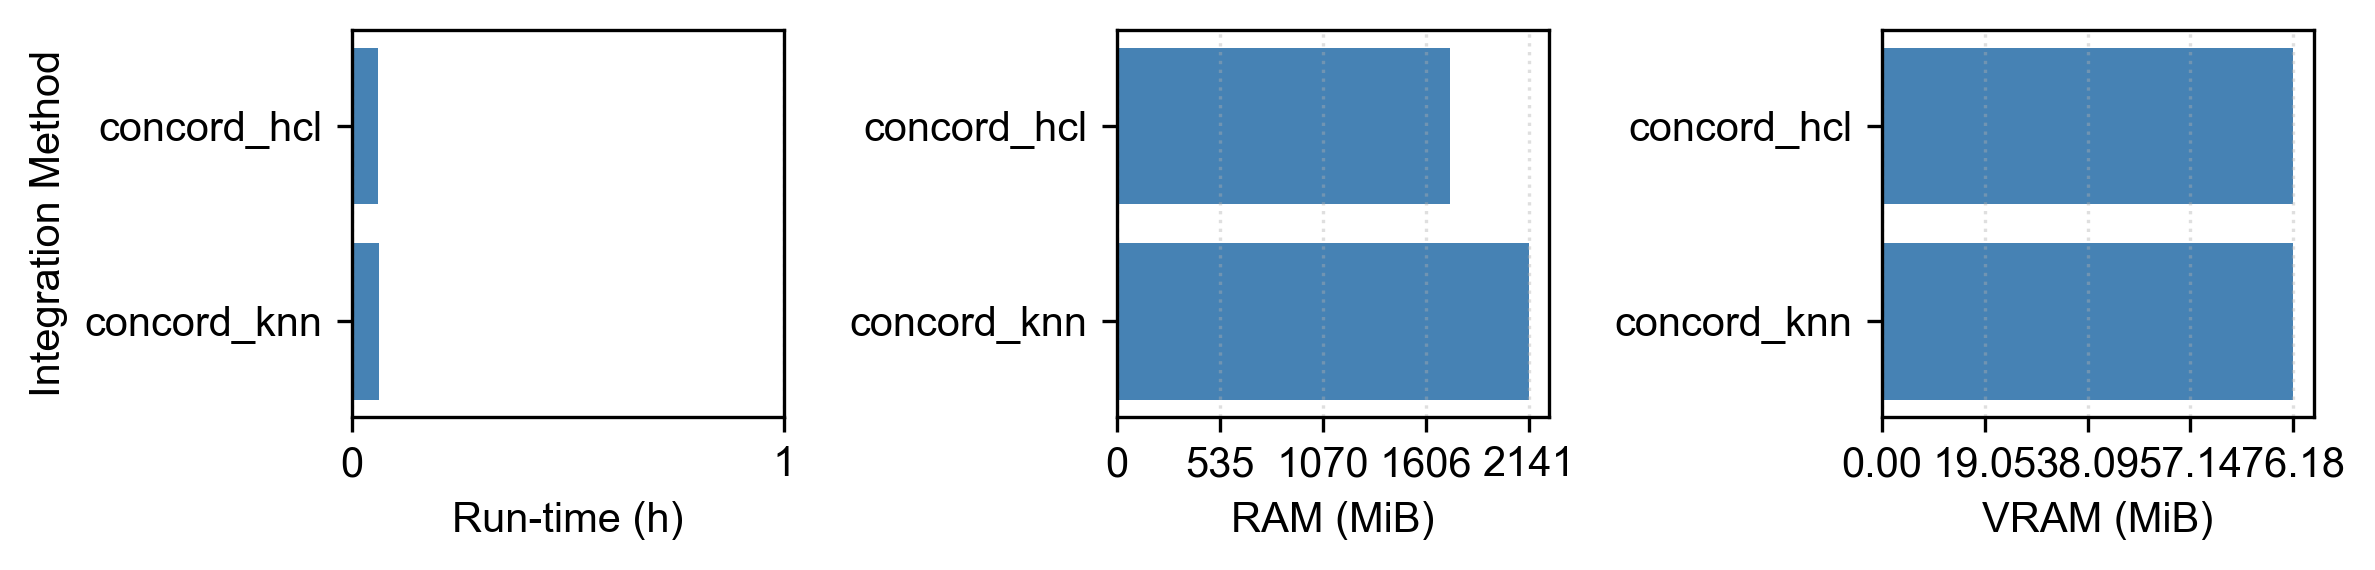

In [10]:
from benchmark_utils import collect_benchmark_logs
bench_df = collect_benchmark_logs(file_name, methods)
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf")


In [12]:
adata.obs.columns

Index(['Sample ID_prep', 'assay_ontology_term_id',
       'cell_type_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'is_primary_data',
       'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'n_genes', 'fpr', 'prep', 'individual',
       'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sample ID',
       'donor_id', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot',
       'RIN score from Frozen tissue Aliquot', 'Autolysis Score',
       'Sample Ischemic Time (mins)', 'scrublet', 'scrublet_score', 'batch',
       'n_counts', 'tissue-individual-prep', 'Broad cell type',
       'Granular cell type', 'introns', 'junctions', 'exons', 'sense',
       'antisense', 'intergenic', 'exon_ratio', 'intron_ratio',
       'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue',
       'Tissue composition', 'Cell types level 2', 'Cell types level 3',
       'Broad cell type numbers', 'Broa

In [15]:
import pandas as pd
pd.crosstab(adata.obs['donor_id'], adata.obs['batch'])

batch,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
donor_id,,,,,,,,,,,,,,,,,,,,,
GTEX-12BJ1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GTEX-13N11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GTEX-144GM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GTEX-145ME,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GTEX-15CHR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GTEX-15EOM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,73,158,74,15
GTEX-15RIE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GTEX-15SB6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GTEX-16BQI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


concord.plotting.pl_embedding - INFO - Plotting concord_hcl with donor_id in UMAP


concord.plotting.pl_embedding - INFO - Plotting concord_knn with donor_id in UMAP


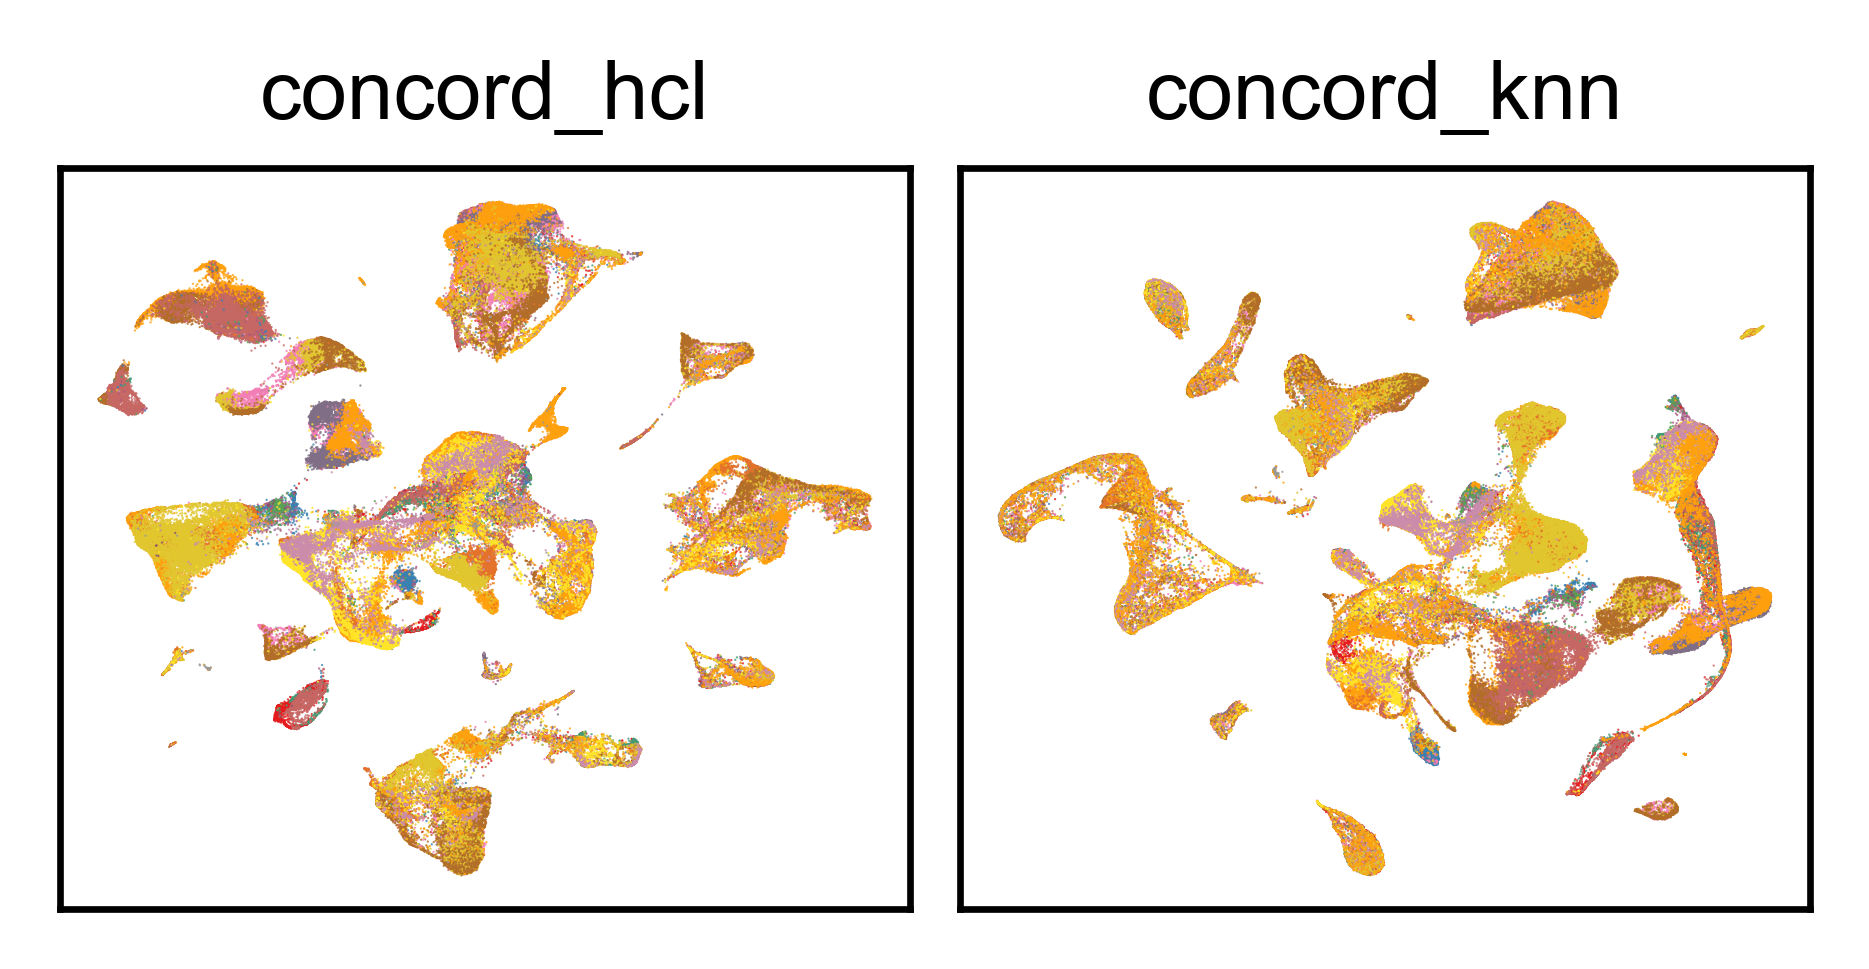

concord.plotting.pl_embedding - INFO - Plotting concord_hcl with Broad cell type in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with Broad cell type in UMAP


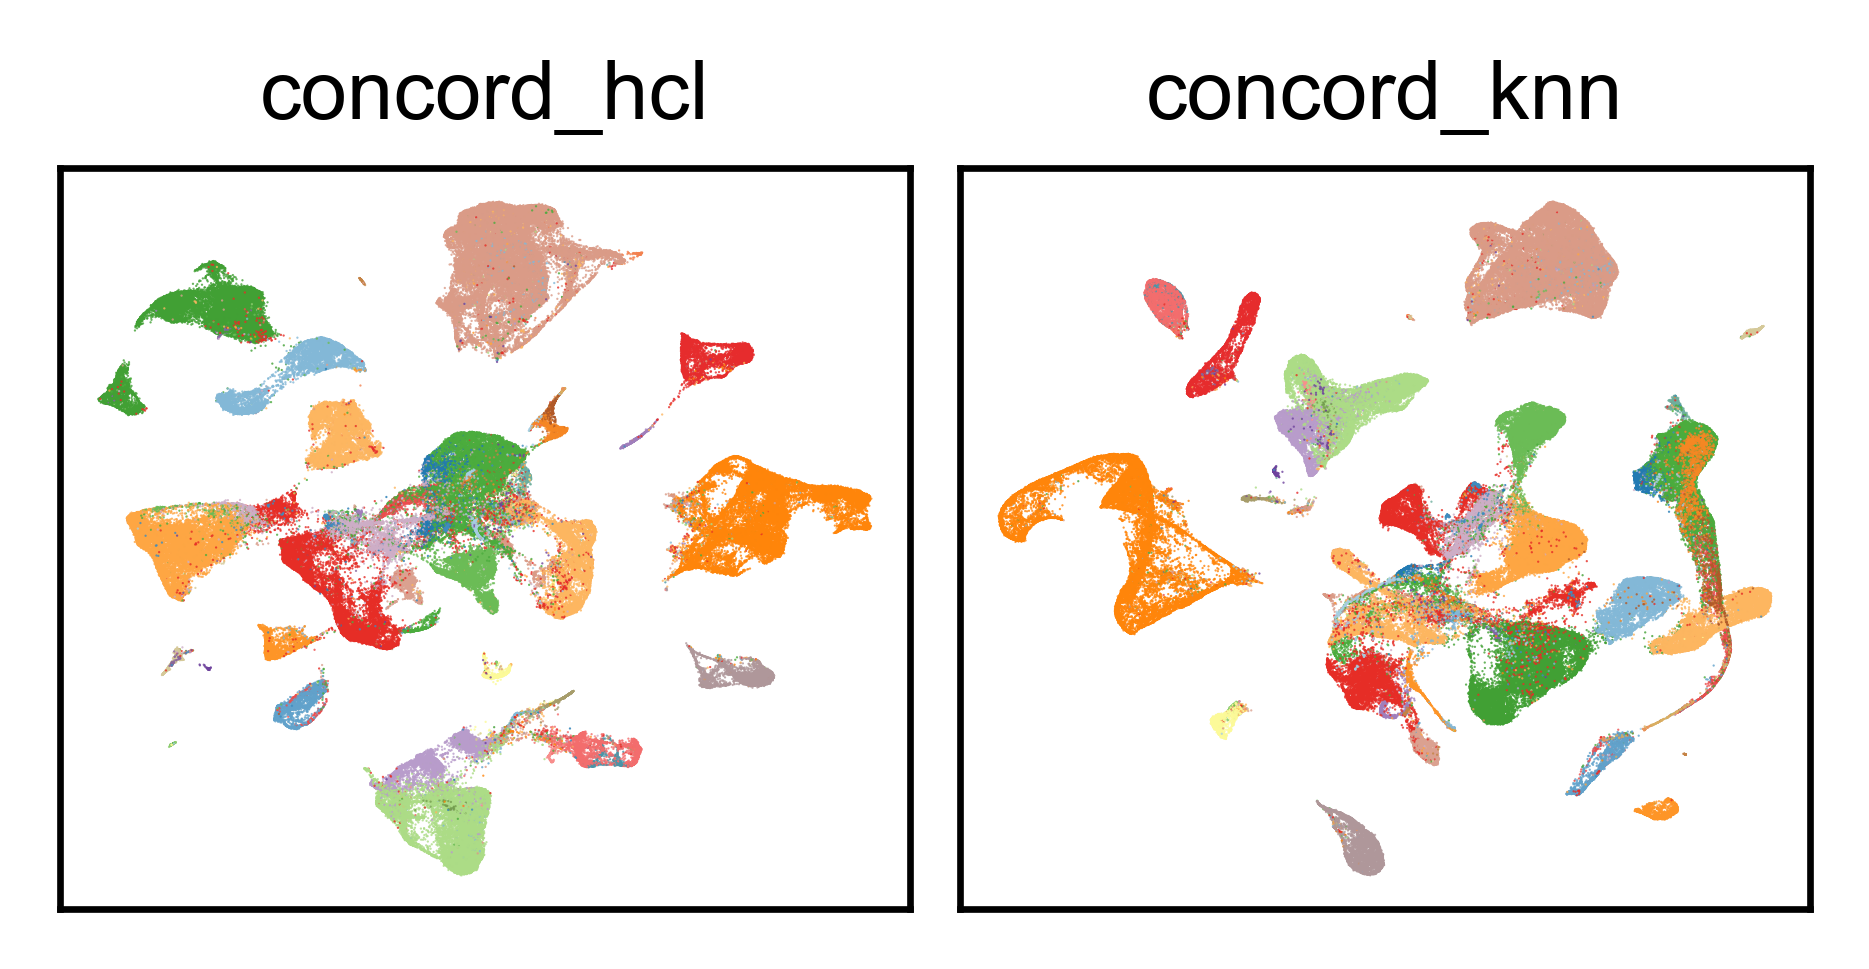

concord.plotting.pl_embedding - INFO - Plotting concord_hcl with Granular cell type in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with Granular cell type in UMAP


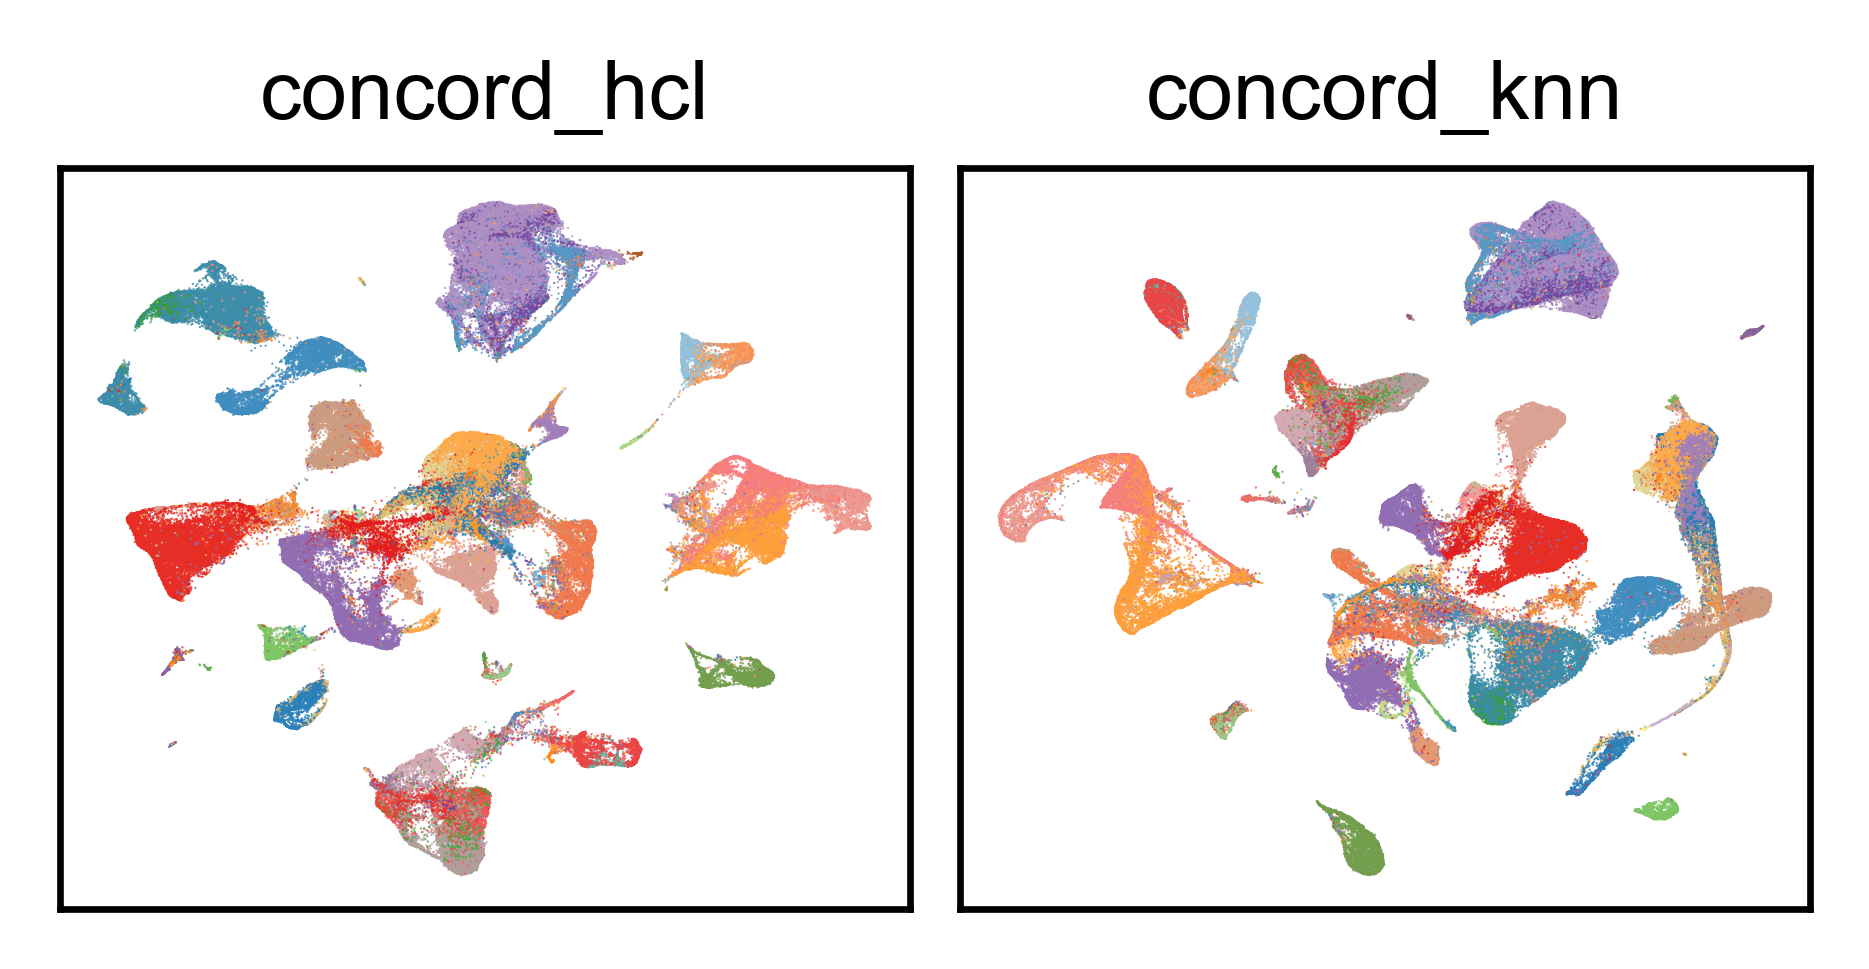

In [14]:
# plot everything
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

show_keys = methods
show_cols = ['donor_id', 'Broad cell type', 'Granular cell type']
basis_types = ['UMAP']

font_size=10
point_size=.3
alpha=0.8
ncols = len(show_keys)
figsize=(ncols * 1.5,1.5)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'donor_id': 'Set1',
       "Broad cell type": 'Paired',
         "Granular cell type": 'Paired'}

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix,
        dpi=600,
        save_format='svg'
    )
